# Notebook "7_Besoin_2_Profil_Ineris"


## Description

Ce notebook "7_Besoin_2_Profil_Ineris" se focalise sur la génération des profils d'INERIS et sur la comparaison à l'aide du dot product.

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Préprocessing des données
- III. Génération des profils
- IV. Changement de la normalisation A (dénominateur est restreint aux quelques congénères)

## Prérequis

### Source de données

Pour que le notebook fonctionne, la base de données "INERIS" doit être disponible dans le même fichier que le notebook. Par ailleurs, cette source doit être au format csv avec le nom "DB_INERIS.csv"

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- seaborn
- matplotlib
- numpy
- scipy
- sklearn

# I. Import des libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy.stats as SS
from sklearn.metrics.pairwise import cosine_similarity
import datetime as dt

# II. Préprocessing des données

## II.a Définition des variables

In [2]:
substances = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

## II.b Chargement des données

In [3]:
data = pd.read_csv('DB_INERIS.csv', sep=';')

data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)
for col in (substances + total_homologue + ['Total DIOXINE', 'Total FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

## II.c Définition des colonnes

In [4]:
columns_process = ['2378-TCDD', '<', '12378-PeCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


## II.d Mise en place de la normalisation A

In [5]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [6]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

## II.e Mise en place de la normalisation C

In [7]:
# Choix de la normalisation des congénère OCDD et OCDF
# Valeur True => Normalisation par la concentration total
# Valeur False => Normalisation avec la définition classique
normalisation_C_disc = True

In [8]:
table_norme_C = table_final.copy()

for col in total_homologue:
    table_final["total homologue"] = 0
    table_final["total homologue"] += table_final[col]
table_norme_C = table_final[table_final["total homologue"] > 0]

print("Nombres d'échantillons restants :", len(table_norme_C), "\nPourcentage restant :", len(table_norme_C)*100/len(table_final))

substance_in = {}
for homologue in total_homologue:
    if(homologue != "OCDD" and homologue != "OCDF"):
        list_sub = []
        text_ref_homologue = homologue.replace("Total ", "")
        table_norme_C[text_ref_homologue] = 0
        for sub in substances:
            if sub.find(text_ref_homologue) != -1:
                list_sub.append(sub)
                table_norme_C[text_ref_homologue] += table_norme_C[sub]
        substance_in[homologue] = list_sub
        text_ref_homologue_2 = text_ref_homologue + "_2"
        table_norme_C[text_ref_homologue_2] = table_norme_C[text_ref_homologue] * 0.9
        table_norme_C = table_norme_C[table_norme_C[text_ref_homologue_2] <= table_norme_C[homologue]]
    else:
        substance_in[homologue] = [homologue]

Nombres d'échantillons restants : 634 
Pourcentage restant : 77.3170731707317


In [9]:
table_norme_C['TOTAL PCDD'] = table_norme_C['TCDD'] + table_norme_C['PeCDD'] + table_norme_C['HxCDD'] + table_norme_C['HpCDD'] + table_norme_C['OCDD']
table_norme_C['TOTAL PCDF'] = table_norme_C['TCDF'] + table_norme_C['PeCDF'] + table_norme_C['HxCDF'] + table_norme_C['HpCDF'] + table_norme_C['OCDF'] 

for homologue in total_homologue:
    for sub in substance_in[homologue]:
        if sub == 'OCDD':
            if(normalisation_C_disc):
                table_norme_C['OCDD'] = table_norme_C['OCDD'] / table_norme_C['TOTAL PCDD']
            else:
                table_norme_C[sub] = 1
        elif sub == 'OCDF':
            if(normalisation_C_disc):
                table_norme_C['OCDF'] = table_norme_C['OCDF'] / table_norme_C['TOTAL PCDF']
            else:
                table_norme_C[sub] = 1
        else:
            table_norme_C[sub] = table_norme_C[sub] / table_norme_C[homologue]
table_norme_C = table_norme_C.fillna(0)
table_norme_C = table_norme_C.replace(np.inf, 0)
renaming = { pre : nex for (pre, nex) in zip(substances, substances_C) }
table_norme_C = table_norme_C.rename(columns = renaming)
print("Nombres d'échantillons restants :", len(table_norme_C), "\nPourcentage restant :", len(table_norme_C)*100/len(table_final))

Nombres d'échantillons restants : 262 
Pourcentage restant : 31.951219512195124


In [10]:
table_total = table_norme_A[["Nom du projet", "Type de point de mesure", "Matrice", "Contexte", "Source", "Fournisseur", "Distance à la source (km)", "Année", "Date de mesure :  Début"] + substances_A].merge(table_norme_C[substances_C], how='left', left_index=True, right_index=True)
table_total = table_total[table_total["Fournisseur"] != "US EPA"]
table_total

,Nom du projet,Type de point de mesure,Matrice,Contexte,Source,Fournisseur,Distance à la source (km),Année,Date de mesure : Début,2378-TCDD_A,...,2378-TCDF_C,12378-PeCDF_C,23478-PeCDF_C,123478-HxCDF_C,123678-HxCDF_C,234678-HxCDF_C,123789-HxCDF_C,1234678-HpCDF_C,1234789-HpCDF_C,OCDF_C
0,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.000087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.000310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.000087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,15/09/2006,0.003422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,15/09/2006,0.000215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,Essais sur déchets sauvages,Source,Emission,Incendie,Cables électriques,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.000254,...,0.012837,0.022013,0.062492,0.072569,0.05894,0.182543,0.059835,0.636906,0.116446,0.308449
816,Essais sur déchets sauvages,Blanc,Emission,Incendie,Blanc,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,Essais sur déchets sauvages,Blanc,Emission,Incendie,Blanc,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,Essais sur déchets sauvages,Source,Emission,Incendie,Cables électriques,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.000490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# III Génération des profils

## III.a Profils avec normalisation A

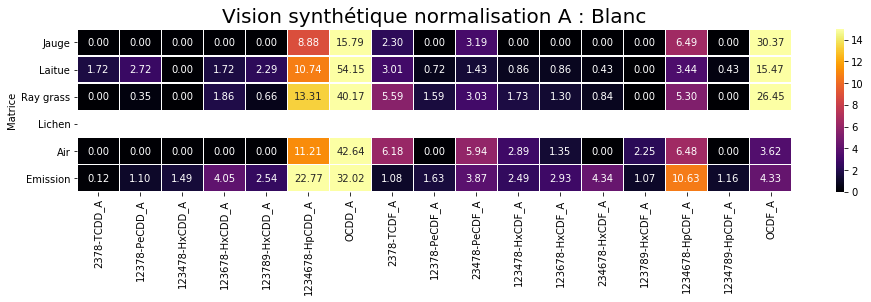

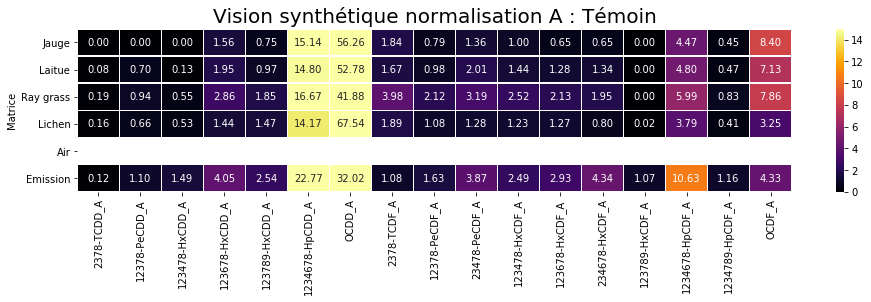

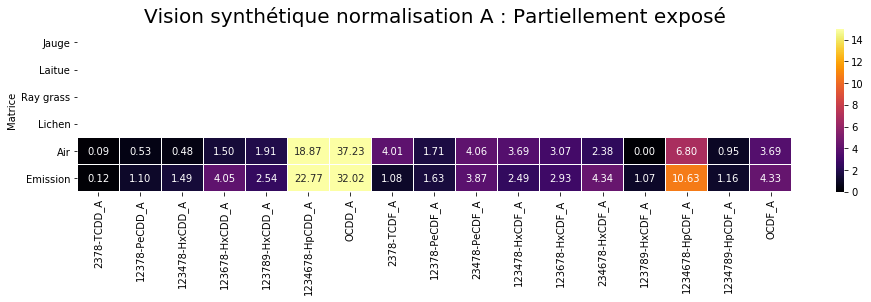

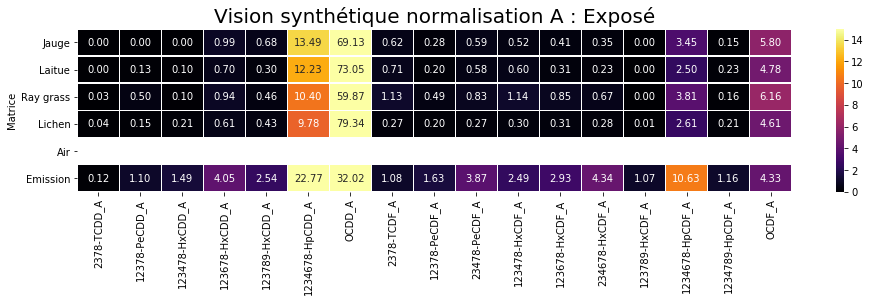

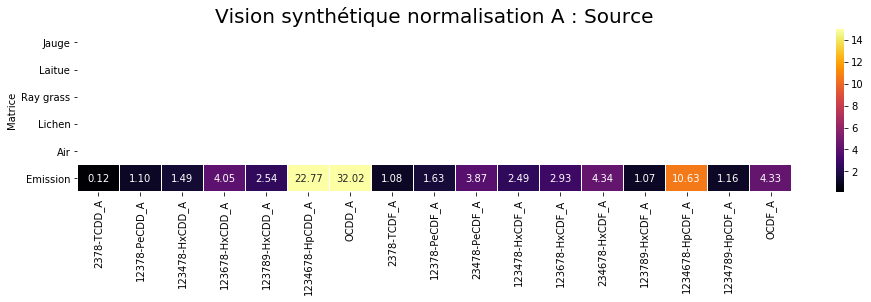

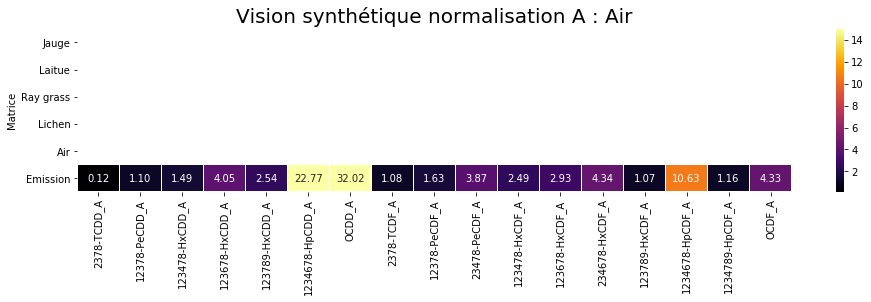

In [11]:
project = 'SIVERT'
varexp = "Matrice"
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source", "Air"]

for mesure in mesure_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == mesure) | (table_total["Type de point de mesure"] == "Source"))][substances_A + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()

    visu = df_analyse_final.groupby([varexp]).median()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation A : " + mesure,fontsize=20)
    sns.heatmap(visu.reindex(["Jauge", "Laitue", "Ray grass", "Lichen", "Air", "Emission"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## III.b Profils avec normalisation C

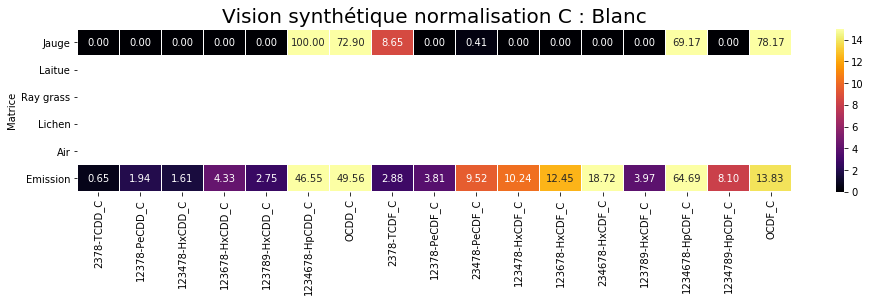

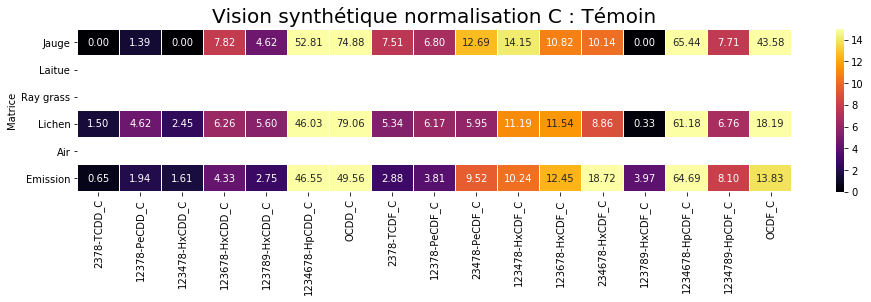

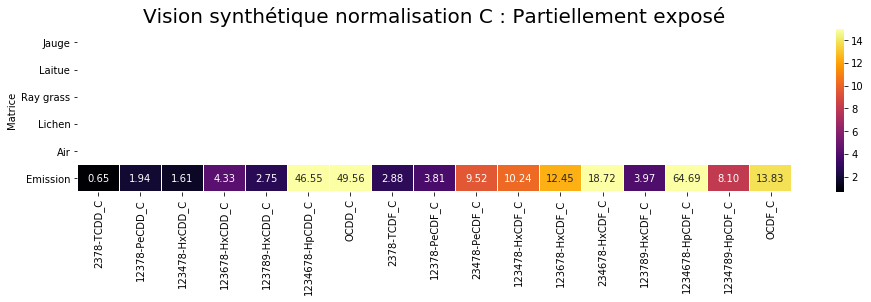

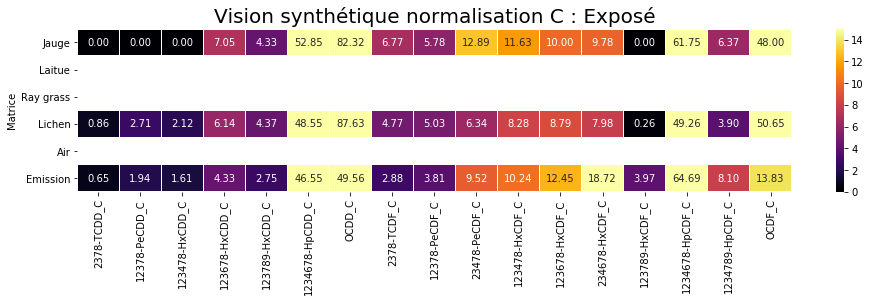

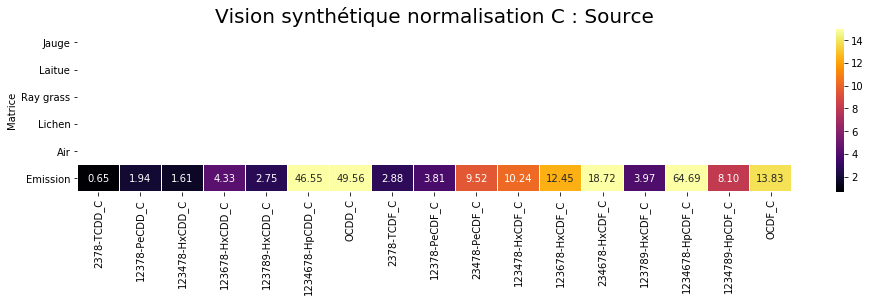

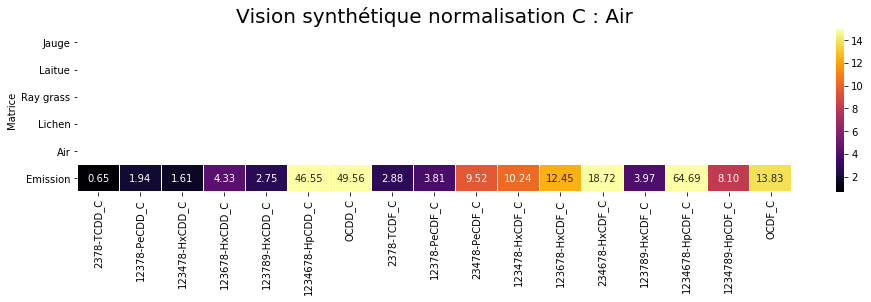

In [12]:
project = 'SIVERT'
varexp = "Matrice"
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source", "Air"]

for mesure in mesure_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == mesure) | (table_total["Type de point de mesure"] == "Source"))][substances_C + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()

    visu = df_analyse_final.groupby([varexp]).median()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation C : " + mesure,fontsize=20)
    sns.heatmap(visu.reindex(["Jauge", "Laitue", "Ray grass", "Lichen", "Air", "Emission"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## III.c Restriction des profils sur certains congénères

In [13]:
substance_restreint = ['123789-HxCDD', '1234678-HpCDD','OCDD', '1234678-HpCDF', 'OCDF']
substance_restreint_A = [sub + '_A' for sub in substance_restreint]
substance_restreint_C = [sub + '_C' for sub in substance_restreint]

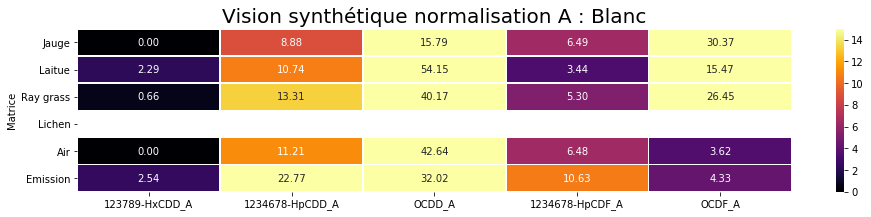

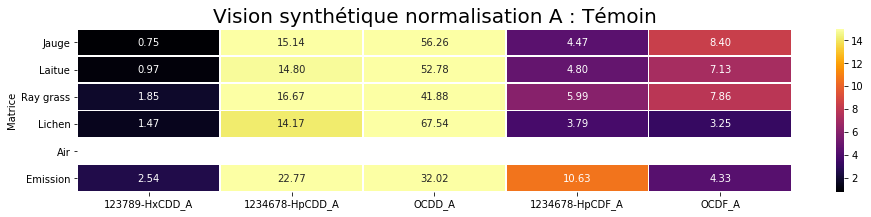

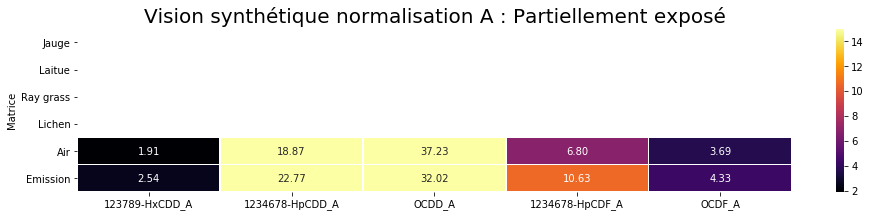

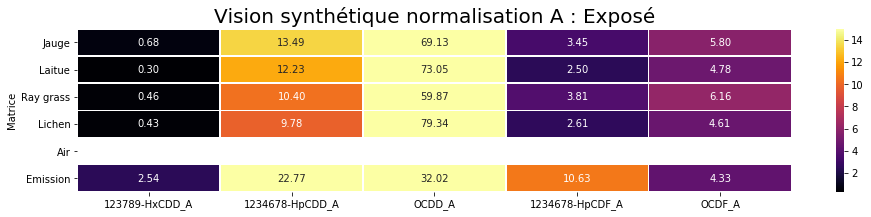

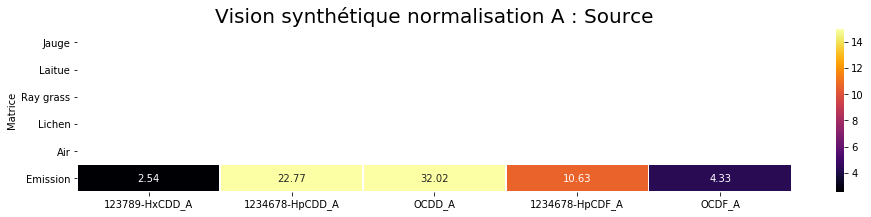

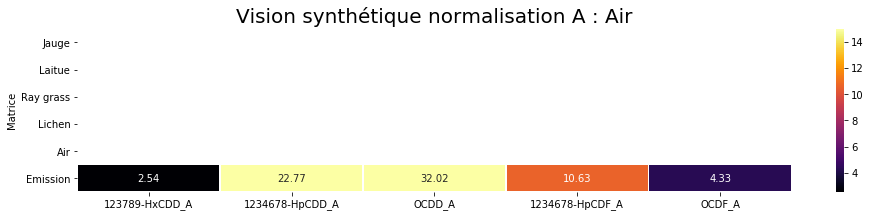

In [14]:
project = 'SIVERT'
varexp = "Matrice"
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source", "Air"]

for mesure in mesure_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == mesure) | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()

    visu = df_analyse_final.groupby([varexp]).median()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation A : " + mesure,fontsize=20)
    sns.heatmap(visu.reindex(["Jauge", "Laitue", "Ray grass", "Lichen", "Air", "Emission"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## III.d Comparaison en fonction de la matrice (dot product)

### Blanc

In [15]:
i = 0
df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Blanc") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
df_analyse_final = df_analyse_final.dropna()
visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Matrice_1', columns='Matrice_2', aggfunc=sum)

Matrice_2,Air,Emission,Jauge,Laitue,Ray grass
Matrice_1,,,,,
Air,1.000000,0.929933,0.575267,0.975759,0.887848
Emission,0.929933,1.000000,0.615984,0.885671,0.856019
Jauge,0.575267,0.615984,1.000000,0.697993,0.881153
Laitue,0.975759,0.885671,0.697993,1.000000,0.952286
Ray grass,0.887848,0.856019,0.881153,0.952286,1.000000


### Témoin

In [16]:
i = 0
df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Témoin") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
df_analyse_final = df_analyse_final.dropna()
visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Matrice_1', columns='Matrice_2', aggfunc=sum)

Matrice_2,Emission,Jauge,Laitue,Lichen,Ray grass
Matrice_1,,,,,
Emission,1.000000,0.921860,0.927663,0.896045,0.962442
Jauge,0.921860,1.000000,0.999785,0.993593,0.991281
Laitue,0.927663,0.999785,1.000000,0.993938,0.992525
Lichen,0.896045,0.993593,0.993938,1.000000,0.974844
Ray grass,0.962442,0.991281,0.992525,0.974844,1.000000


### Exposé

In [17]:
i = 0
df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Exposé") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
df_analyse_final = df_analyse_final.dropna()
visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Matrice_1', columns='Matrice_2', aggfunc=sum)

Matrice_2,Emission,Jauge,Laitue,Lichen,Ray grass
Matrice_1,,,,,
Emission,1.000000,0.890506,0.875196,0.855800,0.885423
Jauge,0.890506,1.000000,0.999356,0.997122,0.999516
Laitue,0.875196,0.999356,1.000000,0.999045,0.998892
Lichen,0.855800,0.997122,0.999045,1.000000,0.997401
Ray grass,0.885423,0.999516,0.998892,0.997401,1.000000


### Distance avec normalisation A

In [18]:
varexp = "Distance à la source (km)"
i = 0
df_similarity = pd.DataFrame(columns=["Distance_1", "Distance_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Exposé") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp , "Type de point de mesure"]].copy()
df_analyse_final = df_analyse_final.dropna()
visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Distance_1', columns='Distance_2', aggfunc=sum)

Distance_2,0,"0,5",1,2
Distance_1,,,,
0,1.000000,0.880418,0.888338,0.914926
"0,5",0.880418,1.000000,0.999841,0.995843
1,0.888338,0.999841,1.000000,0.997277
2,0.914926,0.995843,0.997277,1.000000


### Distance avec normalisation C

In [19]:
varexp = "Distance à la source (km)"
i = 0
df_similarity = pd.DataFrame(columns=["Distance_1", "Distance_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Exposé") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_C + [varexp , "Type de point de mesure"]].copy()
df_analyse_final = df_analyse_final.dropna()
visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Distance_1', columns='Distance_2', aggfunc=sum)

Distance_2,0,"0,5",1,2
Distance_1,,,,
0,1.000000,0.937885,0.939333,0.957651
"0,5",0.937885,1.000000,0.999747,0.986018
1,0.939333,0.999747,1.000000,0.986230
2,0.957651,0.986018,0.986230,1.000000


# IV. Changement de la normalisation A (dénominateur est restreint aux quelques congénères)

## IV.a Profils en fonction de la distance à la source

Distance_2,0,"0,5",1,2
Distance_1,,,,
0,1.000000,0.954683,0.958678,0.967870
"0,5",0.954683,1.000000,0.999786,0.998432
1,0.958678,0.999786,1.000000,0.999276
2,0.967870,0.998432,0.999276,1.000000


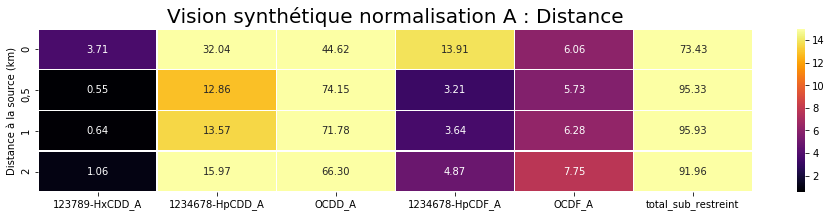

In [20]:
varexp = "Distance à la source (km)"
i = 0
df_similarity = pd.DataFrame(columns=["Distance_1", "Distance_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Exposé") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp , "Type de point de mesure", "Matrice"]].copy()
df_analyse_final = df_analyse_final.dropna()
df_analyse_final["total_sub_restreint"] = np.sum(df_analyse_final[substance_restreint_A], axis=1)
for sub in substance_restreint_A:
    df_analyse_final[sub] = df_analyse_final[sub] / df_analyse_final["total_sub_restreint"]
visu = df_analyse_final.groupby([varexp]).median()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A : Distance",fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Distance_1', columns='Distance_2', aggfunc=sum)

## IV.b Profils en fonction de la matrice

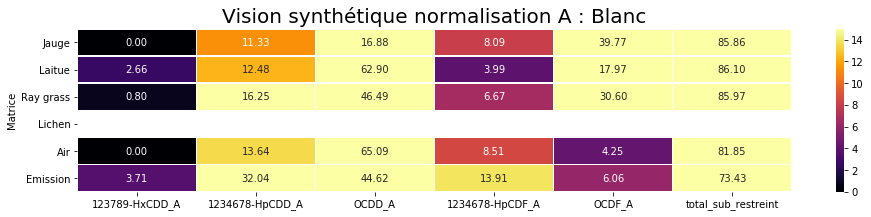

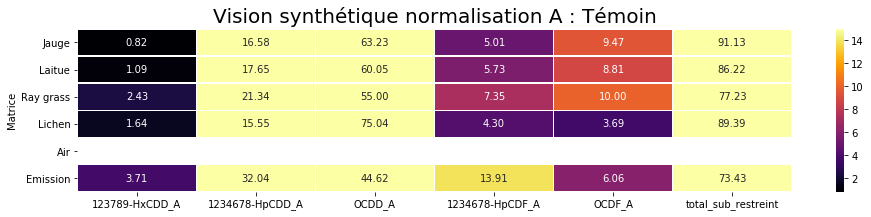

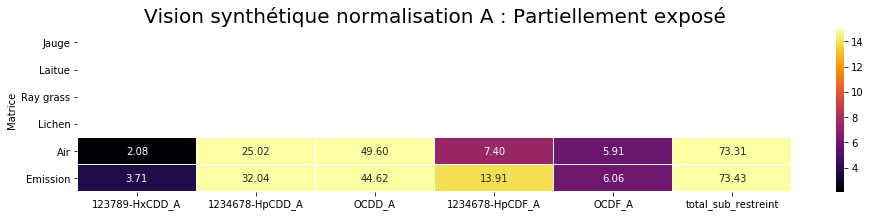

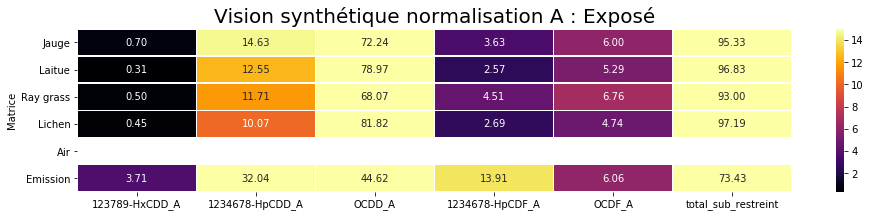

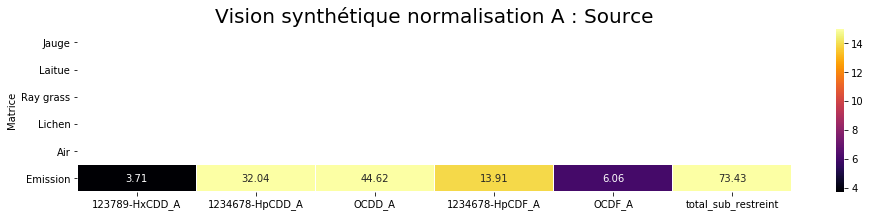

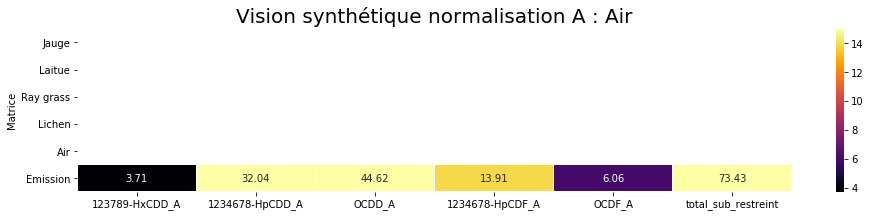

In [21]:
project = 'SIVERT'
varexp = "Matrice"
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source", "Air"]

for mesure in mesure_list:
    df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == mesure) | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()
    df_analyse_final["total_sub_restreint"] = np.sum(df_analyse_final[substance_restreint_A], axis=1)
    for sub in substance_restreint_A:
        df_analyse_final[sub] = df_analyse_final[sub] / df_analyse_final["total_sub_restreint"]

    visu = df_analyse_final.groupby([varexp]).median()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation A : " + mesure,fontsize=20)
    sns.heatmap(visu.reindex(["Jauge", "Laitue", "Ray grass", "Lichen", "Air", "Emission"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## IV.c Tableaux récapitulatif avec les scores de similarités (dot product)

### Témoin

In [22]:
i = 0
varexp = 'Matrice'
df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Témoin") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
df_analyse_final = df_analyse_final.dropna()
df_analyse_final["total_sub_restreint"] = np.sum(df_analyse_final[substance_restreint_A], axis=1)
for sub in substance_restreint_A:
    df_analyse_final[sub] = df_analyse_final[sub] / df_analyse_final["total_sub_restreint"]

visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Matrice_1', columns='Matrice_2', aggfunc=sum)

Matrice_2,Emission,Jauge,Laitue,Lichen,Ray grass
Matrice_1,,,,,
Emission,1.000000,0.970792,0.975249,0.957319,0.985071
Jauge,0.970792,1.000000,0.999790,0.994317,0.996512
Laitue,0.975249,0.999790,1.000000,0.994034,0.997920
Lichen,0.957319,0.994317,0.994034,1.000000,0.989731
Ray grass,0.985071,0.996512,0.997920,0.989731,1.000000


### Exposé

In [25]:
i = 0
varexp = 'Matrice'
df_similarity = pd.DataFrame(columns=["Matrice_1", "Matrice_2", "score"])
df_analyse_final = table_total[(table_total["Nom du projet"] == project) & ((table_total["Type de point de mesure"] == "Exposé") | (table_total["Type de point de mesure"] == "Source"))][substance_restreint_A + [varexp]].copy()
df_analyse_final = df_analyse_final.dropna()
df_analyse_final["total_sub_restreint"] = np.sum(df_analyse_final[substance_restreint_A], axis=1)
for sub in substance_restreint_A:
    df_analyse_final[sub] = df_analyse_final[sub] / df_analyse_final["total_sub_restreint"]

visu = df_analyse_final.groupby([varexp]).median()

for project_1 in visu.index:
    for project_2 in visu.index:
        df_similarity.loc[i] = [
            project_1,
            project_2,
            cosine_similarity(visu[visu.index.isin([project_1])], visu[visu.index.isin([project_2])])[0][0]]
        i += 1
pd.pivot_table(df_similarity, values='score', index='Matrice_1', columns='Matrice_2', aggfunc=sum)

Matrice_2,Emission,Jauge,Laitue,Lichen,Ray grass
Matrice_1,,,,,
Emission,1.000000,0.960192,0.949579,0.941973,0.957799
Jauge,0.960192,1.000000,0.999059,0.997671,0.999579
Laitue,0.949579,0.999059,1.000000,0.999645,0.998349
Lichen,0.941973,0.997671,0.999645,1.000000,0.997094
Ray grass,0.957799,0.999579,0.998349,0.997094,1.000000
